# DEAP Dataset + Understanding Spectrogram

In this part, we shall try something quite different.  That is, we shall convert EEG signals to spectrogram images, where width is time, and height is frequency.  In a nutshell, spectrogram contains both temporal and spatial information, which can then be learned effectively by CNN2D (we hope).

*Note that we will be only predicting the valence.  Feel free to work on the arousal yourself.*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os, pickle

# setting seed so that splitting process and training process can be reproduce
torch.manual_seed(1)

import numpy as np

#refactoring components
#maybe you want to take a look at these components, because we will be using them in the future series
from components.dataset import Dataset, SpecDataset
from components.helper import getLoaders, count_parameters, plot_performance
from components.train import train, evaluate, initialize_weights

Set cuda accordingly.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

Configured device:  cuda


## 1. Understanding spectogram

Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html

In [3]:
path = "data"

In [4]:
_, _, filenames = next(os.walk(path))
filenames = sorted(filenames)
all_data = []
all_label = []
for dat in filenames:
    temp = pickle.load(open(os.path.join(path,dat), 'rb'), encoding='latin1')
    all_data.append(temp['data'])
    all_label.append(temp['labels'][:,:1])   #the first index is valence
    
data = np.vstack(all_data)[:, :32, :]   #shape: (1280, 40, 8064) ==> 1280 samples / 40 samples = 32 participants
label = np.vstack(all_label) #(1280, )  ==> 1280 samples, each with a unique label (depend on the param "stim")    

In [5]:
data.shape

(1280, 32, 8064)

In [6]:
label.shape

(1280, 1)

In [7]:
#let's try get one sample data, the first trial data of the first channel
sample = data[0, 0, :]

sample.shape

(8064,)

Let's define the function for running the spectogram.  

In [8]:
from scipy import signal

def log_specgram(sample, sample_rate, window_size=20, step_size=10, eps=1e-10):
    #expect sample shape of (number of samples, )
    #thus if we want to use this scipy.signal, we have to loop each trial and each channel
    freqs, times, spec = signal.spectrogram(sample,
                                        fs=sample_rate,
                                        nperseg=window_size,
                                        noverlap=step_size)
    return freqs, times, 10 * np.log(spec.T.astype(np.float32) + eps)

Let's call the function

In [9]:
# the sampling rate in which our data is at
sample_rate = 128

# window size refers to the length of time in which we want to create spectograms
# step size refers to how the window is gonna move; here we set it to half the window size, thus it gonna overlap by half

# the intuition of the optimum window length will depend on your application. 
# If your application is such that you need time domain information to be more accurate, 
# reduce the size of your windows. If the application demands frequency domain information 
# to be more specific, then increase the size of the windows. 

window_size = int(sample_rate)  #1s
step_size = sample_rate * 0.5 #0.5s

freqs, times, spectrogram = log_specgram(sample, sample_rate, window_size, step_size)

Let's try to understand each of them.

The <code>freqs</code> is simply the list of all possible frequencies from 0 to sampling rate /2 (128 / 2 = 64).  The reason we can only analyze up to half our sampling rate is according to **Nyquist theory**.

In [10]:
freqs.shape

(65,)

In [11]:
freqs[:]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.])

<code>times</code> is in the unit of seconds which determine when we should start our window, i.e., start at 0 to 1, then 0.5 to 1.5, then 1 to 2, etc.  Since we got overlap of 0.5 seconds, thus, the next window will always overlap with previous window by 0.5 seconds.

In [12]:
times.shape   #8064 / 128 window size * 2 overlap = 126 - 1 = 125   (-1 for the cutoff)

(125,)

In [13]:
times  #(in seconds)

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5,
       17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. ,
       22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5,
       28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5, 33. ,
       33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. , 38.5,
       39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5, 44. ,
       44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. , 49.5,
       50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5, 55. ,
       55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5, 60. , 60.5,
       61. , 61.5, 62. , 62.5])

Last, the <code>spectrogram</code> describes the magnitude for each combination of <code>times</code> and <code>freqs</code>.  Note that we perform <code>log10</code> in order to scale so that lesser frequencies can be seen and not be dominated by only the 60Hz which is the powerline.  This is also called the process of *converting power to decibel* in the formula of 

$$ 10 * \log(P) $$ 

where P is the power.

In [14]:
spectrogram.shape

(125, 65)

In [15]:
#the magnitude at time 0 and frequency 0.125
spectrogram[0, 1]

-113.145386

Let's plot everything.  It's conventional to plot x as time and y as frequency, thus I input <code>spectrogram.T</code>

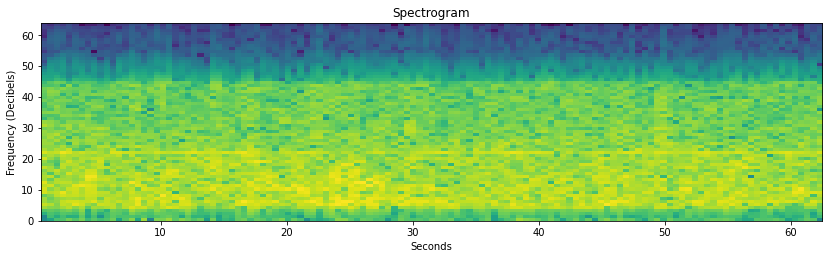

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Spectrogram')
ax1.set_ylabel('Frequency (Decibels)')
ax1.set_xlabel('Seconds')
ax1.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])

Lastly, let's loop through each trial and each channel, and then combine these spectrograms.  Let's first create a holder.

In [17]:
all_spec_data = np.zeros((data.shape[0], data.shape[1], spectrogram.shape[0], spectrogram.shape[1]))
all_spec_data.shape

(1280, 32, 125, 65)

In [18]:
#loop each trial
for i, each_trial in enumerate(data):
#     print(each_trial.shape) # (channel, seq len) (e.g., 32, 8064)
    for j, each_trial_channel in enumerate(each_trial):
#         print(each_trial_channel.shape) # (seq len) (e.g., 8064, ) 
        freqs, times, spectrogram = log_specgram(each_trial_channel, sample_rate, window_size, step_size)
        all_spec_data[i, j, :, :] = spectrogram
        
all_spec_data.shape

(1280, 32, 125, 65)

Here, we got one spectrogram of size (125 times * 65 freq) for each trial and each channel data.  We're done!  

**Note**:  the data is in nice shape ready for inputting into CNN, since CNN expects 4D data (batch, channels, height, width)

Final note is that </code>window_size</code> and </code>step_size</code> create different tradeoffs between time and frequency resolution.  The intuition of the optimum window length will depend on your application. If your application is such that you need time domain information to be more accurate, reduce the size of your windows. If the application demands frequency domain information to be more specific, then increase the size of the windows. 

Finally, we have included this boilet code in the <code>components</code> folder so we do not need to repeat it again.

Let's load this dataset in the next tutorial and try it in CNN2D.